In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Callable
from enum import Enum
import math
import sympy

# Pivoting helper class

This enum class keeps track of types of pivoting and serves to generate the permutation matrices based on the correct enum member.
When no pivoting is used, both rows and columns permutation matrices are the identity matrix.
When partial pivoting is used, the columns permutation matrix is the identity.

The idea of implementing the pivoting is:
$P_r$ is the row permutation matrix and $P_c$ is the columns permutation matrix

$ Ax = b$

$ P_r A P_c x = P_r b$

The methods are applied to solve $ P_r A P_c x = P_r b $ and in the end is returned $P_c x$ to change the values of the incognitos to right place

In [2]:
class Pivoting(Enum):
  NO_PIVOTING = 0,
  PARTIAL_PIVOTING = 1,
  FULL_PIVOTING = 2

  def generate_permutation_matrices(self, A:np.ndarray[np.ndarray]) -> Tuple[np.ndarray[np.ndarray], np.ndarray[np.ndarray]]:
    match self:
      case Pivoting.NO_PIVOTING:
        return (np.identity(len(A)), np.identity(len(A)))
      case Pivoting.PARTIAL_PIVOTING:
        return (Pivoting.__generate_partial_pivot_matrix(A), np.identity(len(A)))
      case Pivoting.FULL_PIVOTING:
        return Pivoting.__generate_full_pivot_matrix(A)


  def __generate_partial_pivot_matrix(A:np.ndarray[np.ndarray]) -> np.ndarray[np.ndarray]:
    n = len(A)
    pivot_matrix = np.identity(n)
    for i in range(n):
      # Find the highest value in the column
      PA = pivot_matrix @ A
      index_highest_value = np.abs(PA[i:, i]).argmax() + i
      pivot_matrix[[i, index_highest_value]] = pivot_matrix[[index_highest_value, i]]
    return pivot_matrix

  def __generate_full_pivot_matrix(A:np.ndarray[np.ndarray]) -> Tuple[np.ndarray[np.ndarray], np.ndarray[np.ndarray]]:
    n = len(A)
    row_permutation_matrix = np.identity(n)
    column_permutation_matrix = np.identity(n)
    for i in range(n):
      PA = row_permutation_matrix @ A @ column_permutation_matrix

      highest_absolute_value = np.abs(PA[i:, i:]).max()
      max_value = np.where(np.abs(PA[i:, i:]) == highest_absolute_value)

      # Use the first found occurence if there is more than one
      index_row_highest_value = max_value[0][0]
      index_column_highest_value = max_value[1][0]

      row_permutation_matrix[[i, index_row_highest_value + i]] = row_permutation_matrix[[index_row_highest_value + i, i]]
      column_permutation_matrix[:, [i, index_column_highest_value + i]] = column_permutation_matrix[:, [index_column_highest_value + i, i]]
      
    return (row_permutation_matrix, column_permutation_matrix)

# Gaussian Elimination

In [3]:
def gauss_method(A: np.ndarray, b:np.ndarray, pivoting = Pivoting.PARTIAL_PIVOTING) -> np.ndarray:
  P_rows, P_columns = pivoting.generate_permutation_matrices(A)

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  for index_col in range(len(A)):
    pivot = PA[index_col][index_col]
    for index_row_below in range(index_col + 1, len(A)):
      ratio = PA[index_row_below][index_col] / pivot
      
      for idx in range(index_col, len(A)):
        PA[index_row_below, idx] -= PA[index_col, idx] * ratio

      Pb[index_row_below] -= Pb[index_col] * ratio
  
  result = np.linalg.solve(PA, Pb)
  return P_columns @ result


# Gaussian elimination with limited precision

In [4]:
def gauss_method_limited_precision(A: np.ndarray, b:np.ndarray, pivoting = Pivoting.PARTIAL_PIVOTING, precision_digits : int = 3) -> np.ndarray:
  A = np.round(A, precision_digits)
  P_rows, P_columns = pivoting.generate_permutation_matrices(A)

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  for index_col in range(len(A)):
    # Round the matrix to the specified precision
    PA = np.round(PA, precision_digits)
    Pb = np.round(Pb, precision_digits)

    pivot = PA[index_col][index_col]
    for index_row_below in range(index_col + 1, len(A)):
      ratio = PA[index_row_below][index_col] / pivot
      ratio = np.round(ratio, precision_digits)
      
      for idx in range(index_col, len(A)):
        PA[index_row_below, idx] -= np.round(PA[index_col, idx] * ratio, precision_digits)

      Pb[index_row_below] -= np.round(Pb[index_col] * ratio, precision_digits)
  
  # Round the matrix to the specified precision
  PA = np.round(PA, precision_digits)
  Pb = np.round(Pb, precision_digits)
  result = np.linalg.solve(PA, Pb)
  result = np.round(result, precision_digits)
  return P_columns @ result

## Tests for gaussian elimination

In [5]:
A = np.array([
  [3,2,4],
  [1,1,2],
  [4,3,-2],], 
dtype=np.float64)
b = np.array([1,2,3], np.float64)
# {-3, 5, 0}
gauss_method(A, b, Pivoting.FULL_PIVOTING)


array([-3.,  5.,  0.])

In [6]:
A = np.array([[1,-7], [5,2]], dtype=np.float64)
b = np.array([-11,-18], dtype=np.float64)
# Solution x=-4, y=1
gauss_method(A,b, Pivoting.PARTIAL_PIVOTING)

array([-4.,  1.])

In [7]:
A = np.array([
  [1.,    2.,     1., -1.],
  [3./2., 1.,     2., 2.],
  [4.,    4.,     3., 4.],
  [2./5., 0.,  1./5., 1.]
], dtype=np.float64)
b = np.array([5., 8., 22., 3.], dtype=np.float64)

# x = 16
# y = -6
# z = -2
# t = -3
gauss_method(A, b, Pivoting.FULL_PIVOTING)

array([16., -6., -2., -3.])

In [8]:
# 1x + 2y - 2z = -15
# 2x + 1y - 5z = -21
# 1x - 4y + 1z = +18 
# Solution {-1, -4, 3}

A = np.array([
  [1, 2, -2],
  [2, 1, -5],
  [1, -4, 1]
], dtype=np.float64)

b = np.array([-15, -21, 18], dtype=np.float64)

gauss_method_limited_precision(A, b, Pivoting.PARTIAL_PIVOTING, 3)

array([-1.005, -4.002,  2.998])

# LU Factoring Method

In [9]:
def is_possible_to_apply_LU_method(A:np.ndarray) -> bool:
  if A.ndim == 2 and A.shape[0] == A.shape[1]: 
    if A.shape == (0,0):
      return True
    return np.linalg.det(A) != 0 and is_possible_to_apply_LU_method(A[1:, 1:])
  return False

# https://jonshiach.github.io/ODEs-book/pages/5.3_LUP_decomposition.html
def lu_factoring(A: np.ndarray, b:np.ndarray, pivoting = Pivoting.NO_PIVOTING) -> np.ndarray:
  assert len(A) == len(b)
  assert A.shape[0] == A.shape[1]
  assert is_possible_to_apply_LU_method(A) == True

  P_rows, P_columns = pivoting.generate_permutation_matrices(A)

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  upper_matrix = PA
  lower_matrix = np.identity(len(A), np.float64)
  
  for index_col in range(len(upper_matrix)):
    pivot = upper_matrix[index_col, index_col] 
    
    for index_row_below in range(index_col + 1, len(upper_matrix)):
      ratio = upper_matrix[index_row_below, index_col]/pivot
      lower_matrix[index_row_below, index_col] = ratio

      for idx in range(index_col, len(A)):
        upper_matrix[index_row_below, idx] -= upper_matrix[index_col, idx] * ratio

  y = np.linalg.solve(lower_matrix, Pb)
  result = np.linalg.solve(upper_matrix, y)
  return P_columns @ result

# LU decomposition method with limited precision

In [10]:
def lu_factoring_limited_precision(A: np.ndarray, b:np.ndarray, pivoting = Pivoting.NO_PIVOTING, precision_digits : int = 3) -> np.ndarray:
  assert len(A) == len(b)
  assert A.shape[0] == A.shape[1]
  assert is_possible_to_apply_LU_method(A) == True

  P_rows, P_columns = pivoting.generate_permutation_matrices(A)

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  upper_matrix = PA
  lower_matrix = np.identity(len(A), np.float64)
  
  for index_col in range(len(upper_matrix)):
    upper_matrix = np.round(upper_matrix, precision_digits)
    lower_matrix = np.round(lower_matrix, precision_digits)

    pivot = upper_matrix[index_col, index_col]
    
    for index_row_below in range(index_col + 1, len(upper_matrix)):
      ratio = upper_matrix[index_row_below, index_col]/pivot
      ratio = np.round(ratio, precision_digits)
      lower_matrix[index_row_below, index_col] = ratio

      for idx in range(index_col, len(A)):
        upper_matrix[index_row_below, idx] -= np.round(upper_matrix[index_col, idx] * ratio, precision_digits)

  upper_matrix = np.round(upper_matrix, precision_digits)
  lower_matrix = np.round(lower_matrix, precision_digits)
  Pb = np.round(Pb, precision_digits)
  y = np.linalg.solve(lower_matrix, Pb)
  y = np.round(y, precision_digits)
  result = np.linalg.solve(upper_matrix, y)
  result = np.round(result, precision_digits)
  return P_columns @ result

## Tests for LU methdod

In [11]:
A = np.array([
  [4.,  2.,  -4.],
  [2.,  10., 4.],
  [-4., 4.,  9.],
], dtype=np.float64)

b = np.array([0., 6., 5.], dtype=np.float64)

# x = 1
# y = 0
# z = 1

lu_factoring(A, b, Pivoting.NO_PIVOTING)

array([1., 0., 1.])

In [12]:
A = np.array([
  [4.,  2.,  -4.],
  [2.,  10., 4.],
  [-4., 4.,  9.],
], dtype=np.float64)

b = np.array([0., 6., 5.], dtype=np.float64)

# x = 1
# y = 0
# z = 1

lu_factoring(A, b, Pivoting.PARTIAL_PIVOTING)

array([1., 0., 1.])

In [13]:
A = np.array([
  [3,2,4],
  [1,1,2],
  [4,3,-2],], 
dtype=np.float64)
b = np.array([1,2,3], np.float64)

# {-3, 5, 0}
lu_factoring(A, b, Pivoting.FULL_PIVOTING)

array([-3.,  5.,  0.])

# Cholesky method

In [14]:
def is_possible_to_apply_Cholesky_method(A:np.ndarray) -> bool:
  if A.ndim == 2 and A.shape[0] == A.shape[1]: 
    if A.shape == (0,0):
      return True
    return np.linalg.det(A) > 0.0 and np.allclose(A, A.T) and is_possible_to_apply_Cholesky_method(A[1:, 1:])
  return False

def cholesky_method(A:np.ndarray, b:np.ndarray, pivoting = Pivoting.NO_PIVOTING) -> np.ndarray:
  assert len(A) == len(b)
  assert A.shape[0] == A.shape[1]
  assert is_possible_to_apply_Cholesky_method(A) == True

  P_rows, P_columns = pivoting.generate_permutation_matrices(A)
  # Cholesky needs a symmetric matrix, the row modifications will also modify the column
  P_columns = P_rows.T

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  G = np.zeros(A.shape)

  for i in range(len(A)):
    for j in range(i + 1):
      sum = 0
      for k in range(j):
        sum += G[i][k] * G[j][k]
      
      if i == j:
        G[i][j] = math.sqrt(PA[i][i] - sum)
      else:
        G[i][j] = (PA[i][j] - sum) / G[j][j]

  G_transpose = G.T
  y = np.linalg.solve(G, Pb)
  x = np.linalg.solve(G_transpose, y)
  return P_columns @ x

# Cholesky with limited precision

In [15]:
def cholesky_method_limited_precision(A:np.ndarray, b:np.ndarray, pivoting = Pivoting.NO_PIVOTING, precision_digits:int=3) -> np.ndarray:
  assert len(A) == len(b)
  assert A.shape[0] == A.shape[1]
  assert is_possible_to_apply_Cholesky_method(A) == True

  A = np.round(A, precision_digits)
  P_rows, P_columns = pivoting.generate_permutation_matrices(A)
  # Cholesky needs a symmetric matrix, the row modifications will also modify the column
  P_columns = P_rows.T

  PA = P_rows @ A @ P_columns
  Pb = P_rows @ b

  G = np.zeros(A.shape)

  for i in range(len(A)):
    G = np.round(G, precision_digits)
    for j in range(i + 1):
      sum = 0
      for k in range(j):
        sum += np.round(G[i][k] * G[j][k], precision_digits)
        sum = np.round(sum, precision_digits)
      
      if i == j:
        G[i][j] = np.round(math.sqrt(np.round(PA[i][i] - sum, precision_digits)), precision_digits)
      else:
        G[i][j] = np.round(np.round(PA[i][j] - sum, precision_digits) / G[j][j], precision_digits)

  G = np.round(G, precision_digits)
  Pb = np.round(Pb, precision_digits)
  G_transpose = G.T
  y = np.linalg.solve(G, Pb)
  y = np.round(y, precision_digits)
  x = np.linalg.solve(G_transpose, y)
  x = np.round(x, precision_digits)
  return P_columns @ x

## Tests for Cholesky method

In [16]:
A = np.array([
  [1.,  1.,  0.],
  [1.,  2., -1.],
  [0., -1.,  3.],
], dtype=np.float64)

b = np.array([2., 1., 5.], dtype=np.float64)

# x = 1
# y = 1
# z = 2

cholesky_method(A, b, Pivoting.FULL_PIVOTING)

array([1., 1., 2.])

In [17]:
A = np.array([
  [4.,  2.,  -4.],
  [2.,  10., 4.],
  [-4., 4.,  9.],
], dtype=np.float64)

b = np.array([0., 6., 5.], dtype=np.float64)

# x = 1
# y = 0
# z = 1

cholesky_method(A, b)

array([1., 0., 1.])

In [18]:
A = np.array([
  [4.,  2.,  -4.],
  [2.,  10., 4.],
  [-4., 4.,  9.],
], dtype=np.float64)

b = np.array([0., 6., 5.], dtype=np.float64)

# x = 1
# y = 0
# z = 1

cholesky_method_limited_precision(A, b)

array([1., 0., 1.])

# Gauss Jacobi

In [19]:
def is_possible_to_apply_Jacobi_method(A:np.ndarray) -> bool:
  if A.ndim == 2 and A.shape[0] == A.shape[1]: 
    spectral_radius_less_than_one = all(map(lambda x: abs(x) < 1.0, np.linalg.eigvals(A)))
    
    rows_criteria = all(map(lambda x: A[x, :].sum() - A[x, x] < A[x, x], range(len(A))))
    columns_criteria = all(map(lambda x: A[:, x].sum() - A[x, x] < A[x, x], range(len(A))))

    diagonally_dominant = rows_criteria or columns_criteria

    return spectral_radius_less_than_one or diagonally_dominant
  return False

def jacobi_method(A:np.ndarray, b:np.ndarray, x:np.ndarray, iterations: int = 10, epsilon : float = 0.0) -> np.ndarray:
  # assert is_possible_to_apply_Jacobi_method(A) == True

  for _ in range(iterations):
    # Diagonal matrix
    D = np.diag(np.diag(A))
    
    # construct a diagonal matrix where each position is 1/(diagonal element of A)
    D_inv = np.linalg.inv(D)

    new_x = D_inv @ (b - ((A - D) @ x))

    if np.abs(new_x - x).max() / np.abs(new_x).max() < epsilon:
      break

    x = new_x

  return x

## Tests for Gauss Jacobi

In [20]:
A = np.array([
  [4.,  2.,  -4.],
  [2.,  10., 4.],
  [-4., 4.,  9.],
], dtype=np.float64)

b = np.array([0., 6., 5.], dtype=np.float64)
# [1,0,1]

jacobi_method(A, b, np.array([0., 0., 0.]), 20)

array([0.63911074, 0.18195205, 0.74674592])

# Gauss Seidel

In [21]:
def is_possible_to_apply_Seidel_method(A:np.ndarray) -> bool:
  return is_possible_to_apply_Jacobi_method(A) and meet_sassenfeld_criterion(A)

def meet_sassenfeld_criterion(A:np.ndarray) -> bool:
  n = len(A)
  beta = np.ones(n)
  A_abs = np.abs(A)
  for i in range(n):
    beta[i] = 0.0
    beta[i] = (A_abs[i, :] @ beta) / A_abs[i, i]

  return all(map(lambda x: x < 1.0, beta))

def seidel_method(A:np.ndarray, b: np.ndarray, x: np.ndarray, iterations : int = 10, epsilon : float = 0.0) -> np.ndarray:
  # assert is_possible_to_apply_Seidel_method(A) == True

  for _ in range(iterations):
    old_x = x.copy()
    for i in range(len(A)):
      x[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i + 1:], x[i + 1:])) / A[i, i]

    if np.abs(x - old_x).max() / np.abs(x).max() < epsilon:
      break

  return x

## Tests for Gauss Seidel

In [22]:
A = np.array([
  [2.0, 1.0, -0.2, 0.2],
  [0.6, 3.5, -0.6, -0.7],
  [-0.1, -0.2, 1.0, 0.2],
  [1.0, 1.2, 0.2, 4.0]], dtype=np.float64)

meet_sassenfeld_criterion(A)

True

In [23]:
A = np.array([
  [25.,  5.,  1.],
  [64.,  8., 1.],
  [144., 12.,  1.],
], dtype=np.float64)

b = np.array([106.8, 177.2, 279.2], dtype=np.float64)

seidel_method(A, b, np.array([1., 2., 5.]), 2)

array([  12.05644,  -54.88202, -798.34312])

# Newton's Method

In [24]:
def is_possible_to_apply_Newton_method(A:np.ndarray) -> bool:
  pass

def generate_jacobi_function(functions: np.ndarray[sympy.core.Expr], vars : np.ndarray[sympy.Symbol]) -> Callable[[np.ndarray], np.ndarray]:
  jacobi_matrix = [[sympy.diff(f, var) for var in vars] for f in functions]
  def jacobi_function(x:np.ndarray) -> np.ndarray:
    return np.array([[f.subs(list(zip(vars, x))) for f in row ] for row in jacobi_matrix], dtype=np.float64)
  return jacobi_function

def generate_F_function(functions: np.ndarray[sympy.core.Expr], vars : np.ndarray[sympy.Symbol]) -> Callable[[np.ndarray], np.ndarray]:
  def F_function(x:np.ndarray) -> np.ndarray:
    return np.array([f.subs(list(zip(vars, x))) for f in functions], dtype=np.float64)
  return F_function

def newton_method(F: Callable[[np.ndarray], np.ndarray], J: Callable[[np.ndarray], np.ndarray], x:np.ndarray, iterations: int = 10) -> np.ndarray:
  for _ in range(iterations):
    s = gauss_method(J(x), -F(x))
    x = x + s
  return x


## Tests for Newton Method

In [25]:
x, x_2 = sympy.symbols('x,x_2')

f1 = 4.*x - x**3. + x_2
f2 = (-x**2.)/9. + (4.*x_2 - x_2**2.)/4. + 1.

funcs = np.array([f1, f2])
vars = np.array([x, x_2])

initial_guess = np.array([-1.0, -2.0])

newton_method(generate_F_function(funcs, vars), generate_jacobi_function(funcs, vars), initial_guess)

array([ 1.93177027, -0.51822368])

In [26]:
x,y = sympy.symbols('x,y')

f1 = (x-2)**2 + (y+3)**2 - 4
f2 = y + 1

funcs = np.array([f1, f2])
vars = np.array([x, y])
F = generate_F_function(funcs, vars)
J = generate_jacobi_function(funcs, vars)

initial_guess = np.array([0.0, 0.0])

newton_method(F, J, initial_guess)

array([ 1.99755859, -1.        ])

# 

# Exercises

# 1) Solve the systems when possible using Gaussian elimitaion, LU decomposition and Cholesky decomposition. With partial pivoting and without partial pivoting. 3 digits rounding should be used.

In [27]:
S1 = np.array([
  [0.0, 3.0, 2.0],
  [1.0, 4.0, 1.0],
  [0.0, 2.0, 5.0],
], np.float64)
b1 = np.array([5.0, 6.0, 7.0], np.float64)

S2 = np.array([
  [-2.0, -2.0, 0.0],
  [1.0, 3.0, -1.0],
  [0.0, -1.0, 2.0],
], np.float64)
b2 = np.array([-1.0, 3.0, 1.0], np.float64)

S3 = np.array([
  [1.0, 2.0, 1.0],
  [2.0, 6.0, 0.0],
  [1.0, 0.0, 4.0],
], np.float64)
b3 = np.array([4.0, 8.0, 5.0], np.float64)

PRECISION = 3

## a) Gaussian elimination

### S1

The first system of equations is not possible to solve without pivoting due to the first pivot being zero.

First let's see what is the true result of the system by solving with the gaussian method without any modifications (excpets the partial pivoting)

In [28]:
gauss_method(S1, b1, Pivoting.PARTIAL_PIVOTING)

array([1., 1., 1.])

Now let's see what is the result using the 3 digits rounding constraint

In [29]:
gauss_method_limited_precision(S1, b1, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([1., 1., 1.])

The result is equal to the real solution and no error were introduced by the lack of precision

### S2

The second system of equations can be solved with no pivoting. But first let's solve using the unmodified gaussian method to find the true solution

In [30]:
gauss_method(S2, b2, Pivoting.NO_PIVOTING)

array([-1.5,  2. ,  1.5])

Now we can solve using the limited precision version

In [31]:
gauss_method_limited_precision(S2, b2, Pivoting.NO_PIVOTING, PRECISION)

array([-1.5,  2. ,  1.5])

And now using the partial pivoting

In [32]:
gauss_method_limited_precision(S2, b2, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([-1.5,  2. ,  1.5])

In this case, the result was the same with and without pivoting, that is due to the diagonal element being the greatest element in absolute value, so no row exchange is done and the row permutation matrix is equal to the identity matrix. But let's see if using the full pivoting helps refining the result

In [33]:
gauss_method_limited_precision(S2, b2, Pivoting.FULL_PIVOTING, PRECISION)

array([-1.5  ,  2.   ,  1.501])

The full pivoting version was a little more imprecise than the others, that is beacuse in the full pivoting version, the number 3 was choosen as the first pivot, and the operations made were 2/3 and 1/3 that results in repeating decimal values and the rounding process affected more this version in such way that the values below the main diagonal were not 0, but very close to zero values like 0.001.

### S3

Let's start once again by calculating the true solution for the system using the unmodified gaussian method

In [34]:
gauss_method(S3, b3, Pivoting.NO_PIVOTING)

array([1., 1., 1.])

Calculating using the gaussian method without pivoting and only 3 decimal places gives us the following result

In [35]:
gauss_method_limited_precision(S3, b3, Pivoting.NO_PIVOTING, PRECISION)

array([1., 1., 1.])

Now using partial pivoting

In [36]:
gauss_method_limited_precision(S3, b3, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([1., 1., 1.])

In [37]:
gauss_method_limited_precision(S3, b3, Pivoting.FULL_PIVOTING, PRECISION)

array([1., 1., 1.])

In this case, the result using pivoting didn't change, that is beacause the operations performed by the method all used less than the specified precision (3 decimal places)

## b) LU decomposition

### S1

The first system is not possible to solve without pivoting. Let's check if it can be solved with LU decomposition, by checking if it meet the constraints imposed by the method

In [38]:
is_possible_to_apply_LU_method(S1)

True

As it is possible to apply the method, let's solve the system and check the result

In [39]:
lu_factoring_limited_precision(S1, b1, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([1., 1., 1.])

Comparing it to the gaussian elimination, both methods were not affected by the lack of precision on the operations and achieved the correct result

### S2

First thing to do is check if it is possible to apply the method

In [40]:
is_possible_to_apply_LU_method(S2)

True

It is! Let's solve the system by LU decomposition

In [41]:
lu_factoring_limited_precision(S2, b2, Pivoting.NO_PIVOTING, PRECISION)

array([-1.5,  2. ,  1.5])

In [42]:
lu_factoring_limited_precision(S2, b2, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([-1.5,  2. ,  1.5])

In [43]:
lu_factoring_limited_precision(S2, b2, Pivoting.FULL_PIVOTING, PRECISION)

array([-1.5  ,  2.   ,  1.501])

As we have already seen before, for the S2 system, the partial pivoting gives the same result as no pivoting at all.

The LU method was able to find the exact solution with both partial and no pivoting.

The same behavior of the full pivoing being worse were noted in the LU decomposition, but that is because the first pivot choose is the number 3 and the next operations are more affected by the rounding process

### S3

Let's check if it is possible to apply the method

In [44]:
is_possible_to_apply_LU_method(S3)

True

Solving S3 with LU decomposition

In [45]:
lu_factoring_limited_precision(S3, b3, Pivoting.NO_PIVOTING, PRECISION)

array([1., 1., 1.])

In [46]:
lu_factoring_limited_precision(S3, b3, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([1., 1., 1.])

In [47]:
lu_factoring_limited_precision(S3, b3, Pivoting.FULL_PIVOTING, PRECISION)

array([1., 1., 1.])

For this system all pivoting versions find the correct solution

## c) Cholesky decomposition

### S1

Solving the system S1 without pivoting is not possible.

Let's check if it is possible to solve using the Cholesky decomposition

In [48]:
is_possible_to_apply_Cholesky_method(S1)

False

It is not possible to solve with Cholesky, as the method require that the matrix representing the system to be symmetric

### S2

This system falls in the same problem as the S1. But let's check if it is possible to apply the Cholesky method

In [49]:
is_possible_to_apply_Cholesky_method(S2)

False

### S3

Verifying if it's possible to apply Cholesky method

In [50]:
is_possible_to_apply_Cholesky_method(S3)

True

This system is possible to solve with Cholesky, as it have all the requirements needed by the method

In [51]:
cholesky_method_limited_precision(S3, b3, Pivoting.NO_PIVOTING, PRECISION)

array([1., 1., 1.])

The Cholesky method assumes a symetric matrix, so the partial pivoting is not possible, as only changing rows could end up in a non symetrical matrix that is not possible to apply the method. I've implemented the Cholesky in such manner that even with partial pivoting the code also exchange the columns using the transpose of the rows permutation matrix.

In [52]:
cholesky_method_limited_precision(S3, b3, Pivoting.PARTIAL_PIVOTING, PRECISION)

array([0.977, 1.008, 1.006])

In [53]:
cholesky_method_limited_precision(S3, b3, Pivoting.FULL_PIVOTING, PRECISION)

array([0.979, 1.007, 1.005])

The results with pivoting were worse than the non pivoting version. 

# 2

In [54]:
S  = np.array([
  [1.0, 1.0, 3.0],
  [1.0, 1.0, 4.0],
  [5.0, 2.0, 1.0]
], np.float64)

b = np.array([-2.0, -3.0, 4.0], np.float64)


## a) For applying the LU decomposition it's required that the determinant of the matrix must be different from zero.

$ \begin{matrix}
1.0 & 1.0 & 3.0 & 1.0 & 1.0 \\
\alpha &   1.0 & 4.0 & \alpha &   1.0 \\
5.0 & 2.0 & 1.0 & 5.0 & 2.0 \\
\end{matrix}
$

$ det = 0.0 $

$1.0 + 20.0 + 6.0\alpha - 15.0 - 8.0 - \alpha = 0.0$

$5.0\alpha - 2.0 = 0.0$

$ 5.0\alpha = 2.0 $

$ \alpha = 2.0 / 5.0 $ 

For all values of $\alpha \neq 0.4$ it's possible to apply the LU decomposition 

## b) It is not possible to apply Cholesky decomposition, as it require a symmetric matrix and there is no possible value of $\alpha$ that turn the matrix into a symmetric one

## c) Solving with Gaussian elimination without pivoting

It's not possible to solve with Gaussian Elimination without pivoting, because on the first step the second row pivot will be zeroed and it will generate a division by zero exception

# 3

In [55]:
S = np.array([
  [17.0, -2.0, -3.0],
  [-5.0, 21.0, -2.0],
  [-5.0, -5.0, 22.0]
], np.float64)

b = np.array([500.0, 200.0, 30.0], np.float64)

## a) Verify Gauss Jacobi and Gauss Seidel convergency conditions

In [56]:
is_possible_to_apply_Jacobi_method(S)

True

In [57]:
is_possible_to_apply_Seidel_method(S)

True

Both methods can be applied to the system. To apply Jacobi it's necessary that the system have an spectral radius less than one or to be diagonally dominant. For Seidel it also has to meet the Sassenfeld criteria.

## b) Apply Gauss Seidel and Gauss Jacobi to the system

In [58]:
x_0 = np.array([34.0, 19.0, 13.0], np.float64)
MAX_ITERATIONS = 2
MAX_ERROR = 0.0025

True solution

In [59]:
gauss_method(S, b, Pivoting.NO_PIVOTING)

array([33.99631415, 18.89282676, 13.38389566])

Gaus Jacobi

In [60]:
jacobi_method(S, b, x_0.copy(), MAX_ITERATIONS, MAX_ERROR)

array([33.94117647, 18.85714286, 13.40909091])

Gauss Seidel

In [61]:
seidel_method(S, b, x_0.copy(), MAX_ITERATIONS, MAX_ERROR)

array([33.98626402, 18.88816489, 13.38055203])

Comparing with the exact solution provided by the gaussian elimination method. The seidel method achieved a better solution

# 4

In [62]:
S = np.array([
  [2.0, 5.0],
  [3.0, 1.0],
], np.float64)

b = np.array([-3.0, 2.0], np.float64)

## a) Solving with Jacobi and Seidel

First let's see what is the expected result using the Gaussian Elimination

In [63]:
gauss_method(S, b, Pivoting.NO_PIVOTING)

array([ 1., -1.])

In [64]:
ITERATIONS = 3
x_0 = np.array([0.0, 0.0], np.float64)

In [65]:
is_possible_to_apply_Jacobi_method(S)

False

In [66]:
jacobi_method(S, b, x_0.copy(), ITERATIONS)

array([-17.75,  21.5 ])

In [67]:
is_possible_to_apply_Seidel_method(S)

False

In [68]:
seidel_method(S, b, x_0.copy(), ITERATIONS)

array([-139.625,  420.875])

Both methods are diverging, but the system doesn't met the criterias for applying any of the methods

Let's see grafically what is happening.

First we will plot the lines and see where they intercept

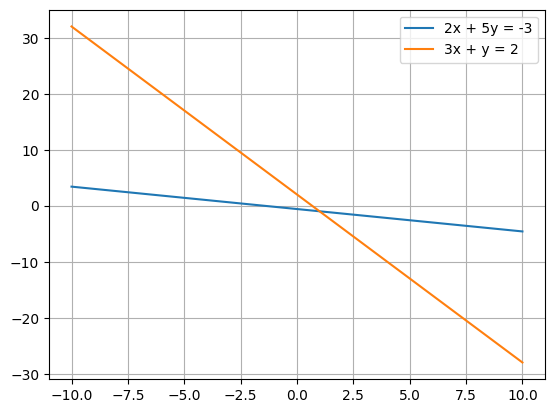

In [69]:
# Rearranging the equations, to isolate the y value in terms of x

# 2x + 5y = -3
# 5y = -3 - 2x
# y = (-3 - 2x) / 5
f1 = lambda x: (-3 - 2*x) / 5

# 3x + y = 2
# y = 2 - 3x
f2 = lambda x: 2 - 3*x

INTERVAL_START = -10
INTERVAL_END = 10
plt.plot([INTERVAL_START, INTERVAL_END], [f1(INTERVAL_START), f1(INTERVAL_END)], label='2x + 5y = -3')
plt.plot([INTERVAL_START, INTERVAL_END], [f2(INTERVAL_START), f2(INTERVAL_END)], label='3x + y = 2')

plt.grid()
plt.legend()
plt.show()

Now let's see the iterations of each method and plot

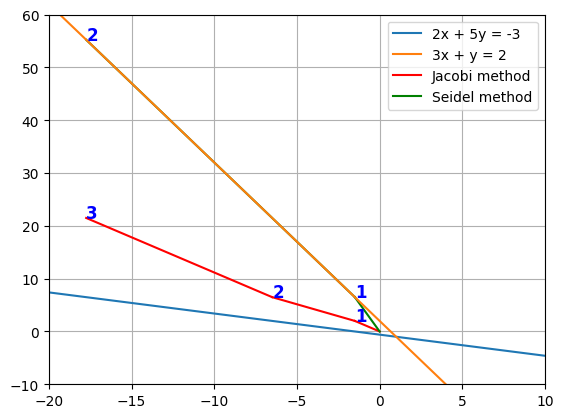

In [70]:
jacobi_results = []
seidel_results = []

x_0_jacobi = x_0.copy()
x_0_seidel = x_0.copy()
for _ in range(ITERATIONS):
  x_0_jacobi = jacobi_method(S, b, x_0_jacobi.copy(), 1)
  jacobi_results.append(x_0_jacobi)

  x_0_seidel = seidel_method(S, b, x_0_seidel.copy(), 1)
  seidel_results.append(x_0_seidel)

graphic_limits_x = [-20, 10]
graphic_limits_y = [-10, 60]

last_jacobi = [0, 0]
last_seidel = [0, 0]
for index in range(ITERATIONS):
  new_jacobi = [jacobi_results[index][0], jacobi_results[index][1]]
  if graphic_limits_x[0] < new_jacobi[0] < graphic_limits_x[1] and graphic_limits_y[0] < new_jacobi[1] < graphic_limits_y[1]:
    plt.plot([last_jacobi[0], new_jacobi[0]], [last_jacobi[1], new_jacobi[1]], color='r')
    plt.text(jacobi_results[index][0], jacobi_results[index][1], f'{index + 1}', color='b', fontdict={'size': 12, 'weight': 'bold'})
  last_jacobi = new_jacobi

  new_seidel = [seidel_results[index][0], seidel_results[index][1]]
  if graphic_limits_x[0] < new_seidel[0] < graphic_limits_x[1] and graphic_limits_y[0] < new_seidel[1] < graphic_limits_y[1]:
    plt.plot([last_seidel[0], new_seidel[0]], [last_seidel[1], new_seidel[1]], color='g')
    plt.text(seidel_results[index][0], seidel_results[index][1], f'{index + 1}', color='b', fontdict={'size': 12, 'weight': 'bold'})
  last_seidel = new_seidel

# Plotting the two lines
start = graphic_limits_x[0]
end = graphic_limits_x[1]
plt.plot([start, end], [f1(start), f1(end)], label='2x + 5y = -3')
plt.plot([start, end], [f2(start), f2(end)], label='3x + y = 2')

plt.xlim(graphic_limits_x[0], graphic_limits_x[1])
plt.ylim(graphic_limits_y[0], graphic_limits_y[1])
plt.grid()

# Add a label that collor red is the Jacobi method and green is the Seidel method
plt.plot([], [], color='r', label='Jacobi method')
plt.plot([], [], color='g', label='Seidel method')
plt.legend()
plt.show()

It is possible to observe in the graph that both methods are diverging. The Seidel method is everytime more close to the orange line.


## b) Exchanging the rows 

In [71]:
S = np.array([
  [3.0, 1.0],
  [2.0, 5.0],
], np.float64)

b = np.array([2.0, -3.0], np.float64)

In [72]:
gauss_method(S, b, Pivoting.NO_PIVOTING)

array([ 1., -1.])

In [73]:
is_possible_to_apply_Jacobi_method(S)

True

In [74]:
jacobi_method(S, b, x_0.copy(), ITERATIONS)

array([ 0.95555556, -0.94666667])

In [75]:
is_possible_to_apply_Seidel_method(S)

True

In [76]:
seidel_method(S, b, x_0.copy(), ITERATIONS)

array([ 0.99407407, -0.99762963])

The results are now converging to the right solution. Lets plot the iterations values

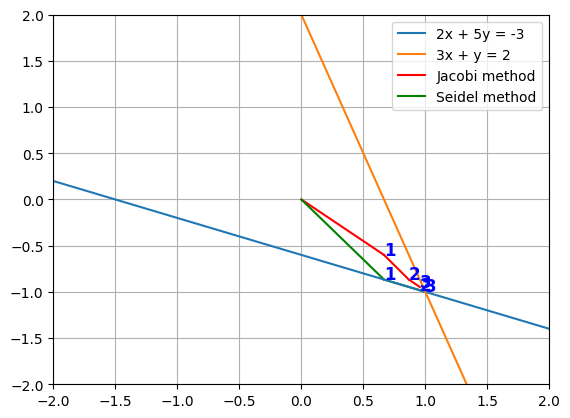

In [77]:
jacobi_results = []
seidel_results = []

x_0_jacobi = x_0.copy()
x_0_seidel = x_0.copy()
for _ in range(ITERATIONS):
  x_0_jacobi = jacobi_method(S, b, x_0_jacobi.copy(), 1)
  jacobi_results.append(x_0_jacobi)

  x_0_seidel = seidel_method(S, b, x_0_seidel.copy(), 1)
  seidel_results.append(x_0_seidel)

graphic_limits_x = [-2, 2]
graphic_limits_y = [-2, 2]

last_jacobi = [0, 0]
last_seidel = [0, 0]
for index in range(ITERATIONS):
  new_jacobi = [jacobi_results[index][0], jacobi_results[index][1]]
  if graphic_limits_x[0] < new_jacobi[0] < graphic_limits_x[1] and graphic_limits_y[0] < new_jacobi[1] < graphic_limits_y[1]:
    plt.plot([last_jacobi[0], new_jacobi[0]], [last_jacobi[1], new_jacobi[1]], color='r')
    plt.text(jacobi_results[index][0], jacobi_results[index][1], f'{index + 1}', color='b', fontdict={'size': 12, 'weight': 'bold'})
  last_jacobi = new_jacobi

  new_seidel = [seidel_results[index][0], seidel_results[index][1]]
  if graphic_limits_x[0] < new_seidel[0] < graphic_limits_x[1] and graphic_limits_y[0] < new_seidel[1] < graphic_limits_y[1]:
    plt.plot([last_seidel[0], new_seidel[0]], [last_seidel[1], new_seidel[1]], color='g')
    plt.text(seidel_results[index][0], seidel_results[index][1], f'{index + 1}', color='b', fontdict={'size': 12, 'weight': 'bold'})
  last_seidel = new_seidel

# Plotting the two lines
start = graphic_limits_x[0]
end = graphic_limits_x[1]
plt.plot([start, end], [f1(start), f1(end)], label='2x + 5y = -3')
plt.plot([start, end], [f2(start), f2(end)], label='3x + y = 2')

plt.xlim(graphic_limits_x[0], graphic_limits_x[1])
plt.ylim(graphic_limits_y[0], graphic_limits_y[1])
plt.grid()

# Add a label that collor red is the Jacobi method and green is the Seidel method
plt.plot([], [], color='r', label='Jacobi method')
plt.plot([], [], color='g', label='Seidel method')
plt.legend()
plt.show()

## c) Comparing the versions

When the rows were exchanged, the matrix representing the system became dyagonally dominant, once the highest values were placed in the main diagonal and thus the criteria for applying both methods were satisfied.

With the conditions to apply the methods satisfied, the methods have converged to the right solution of the system.

# 5 Solve the non linear system with Newton Method

In [78]:
x, y, z = sympy.symbols('x,y,z')

f1 = 3.0*sympy.sin(x)  -4.0 * y -12.0 * z - 1.0
f2 = 4.0*(x**2) - 8.0*y - 10.0*z + 5.0
f3 = 2.0*(sympy.E ** x) + 2.0*y + 3.0*z - 8.0

funcs = np.array([f1, f2, f3])
vars = np.array([x, y, z])

x_0 = np.array([0.0, 0.0, 0.0], np.float64)
ITERATIONS = 10

newton_method(generate_F_function(funcs, vars), generate_jacobi_function(funcs, vars), x_0.copy(), ITERATIONS)

array([ 1.06999055,  1.76139911, -0.45116738])